In [ ]:
# https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

from sklearn.preprocessing import StandardScaler,FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


In [ ]:
import pickle

def open_file(file):
  with open(file, 'rb') as x:
    return pickle.load(x)

y_test1 = open_file('y_test1.pkl')
X_test_scale_df1 = open_file('X_test_scale_df1.pkl')
y_train1 = open_file('y_train1.pkl')
X_train_scale_df1 = open_file('X_train_scale_df1.pkl')

In [ ]:
X_train_scale_df1.shape

(1029, 1224)

In [ ]:
X = pd.concat([X_train_scale_df1, X_test_scale_df1])


In [ ]:
y= pd.concat([y_train1, y_test1])

In [ ]:
# # Filtering Step 1
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.0) # remove the features that have the same value in all samples.
filtered_features = pd.DataFrame(selector.fit_transform(X_train_scale_df1), columns=selector.get_feature_names_out())

# # Filtering Step 2
final_features = filtered_features.T.drop_duplicates().T # remove duplicated features, columns that are exactly the same that another column

X_train_filtered = X_train_scale_df1[final_features.columns]
X_test_filtered = X_test_scale_df1[final_features.columns]



In [ ]:
def fun(model, param_grid):
    scaler = StandardScaler()
    selector = SelectKBest(f_classif)
    smote = SMOTE(random_state=42)
    kfcv = KFold(random_state=42, shuffle=True)

    pipe = ImbPipeline(steps=[("scaler", scaler), ("selector", selector), ("smote", smote), ("model", model)])
    clf = GridSearchCV(pipe, param_grid, cv=kfcv, refit=True)

    # Perform feature selection and hyperparameter tuning
    clf.fit(X_train_filtered, y_train1)

    best_model = clf.best_estimator_
    best_parameters = clf.best_params_

    best_selector = best_model.named_steps['selector']
    selected_features = best_selector.get_support()

    # Apply feature selection to the test set
    X_test_filtered_selected = X_test_filtered.iloc[:, selected_features]

    # Fit the model with the best hyperparameters and selected features
    best_model.fit(X_train_filtered.iloc[:, selected_features], y_train1)

    # Make predictions on the test set
    test_pred_model = best_model.predict(X_test_filtered_selected)
    pred_test= pd.DataFrame(test_pred_model)



    # Calculate evaluation metrics
    f1 = f1_score(y_test1, test_pred_model)
    accuracy = accuracy_score(y_test1, test_pred_model)
    precision = precision_score(y_test1, test_pred_model)
    recall = recall_score(y_test1, test_pred_model)
    results = [accuracy, f1, precision, recall]
    outputs = [X_test_filtered_selected.columns, best_parameters, clf.best_score_, best_model]

    cm = confusion_matrix(y_test1, test_pred_model)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')



    #roc curve
    y_pred_probs = best_model.predict_proba(X_test_filtered_selected)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test1, y_pred_probs)
    roc_auc = auc(fpr, tpr)


    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax2.legend(loc = 'lower right')
    ax2.plot([0, 1], [0, 1],'k--')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')


    fig3 = plt.figure()

    ax3 = fig3.add_subplot(111)

# Calculate PR curve
    precision, recall, thresholds = precision_recall_curve(y_test1, y_pred_probs )
    auprc = auc(recall, precision)

# Plot PR curve
    ax3.plot(recall, precision, color='b',
          label='AUPRC = %0.2f' % auprc)
    ax3.legend(loc='lower left')

    ax3.set_xlim([0, 1])
    ax3.set_ylim([0, 1])
    ax3.set_ylabel('Precision')
    ax3.set_xlabel('Recall')




    return {"selected_features":selected_features,
            "best_parameters":best_parameters,
             "best_model":best_model, "results":results,
            "accuracy":accuracy,
            "prediction_probabilities": y_pred_probs}

# **KNN**

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1010] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1010] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1010] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/loca

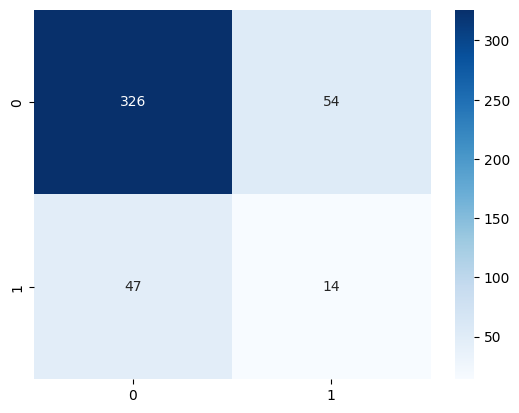

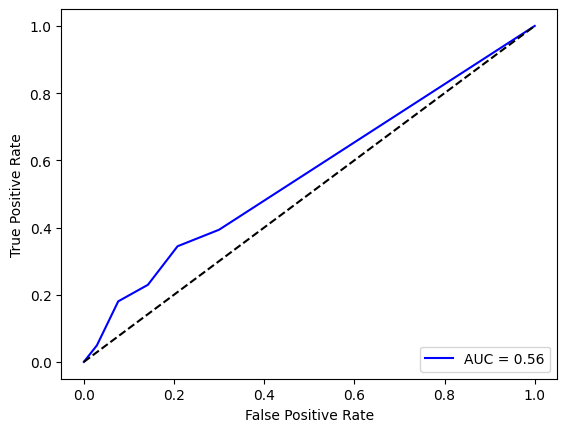

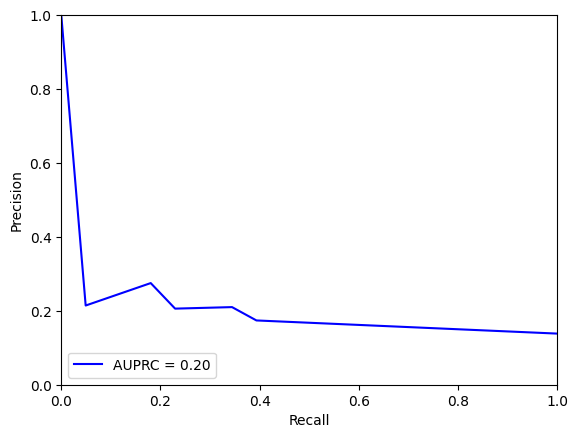

In [ ]:
param_grid_knn = {
    "selector__k": [2, 3, 4, 5, 6, 7, 8, 9, 10,15,20,30,50,70,100,130,400,600,800],
    "model__n_neighbors": [3, 5, 15, 30, 45, 60],
}

model1 = KNeighborsClassifier()

knn_results = fun(model1, param_grid_knn)


# **Random Forest**

Streaming output truncated to the last 5000 lines.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1010] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1010] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: R

0.2452074296955908 0.16102698278960786


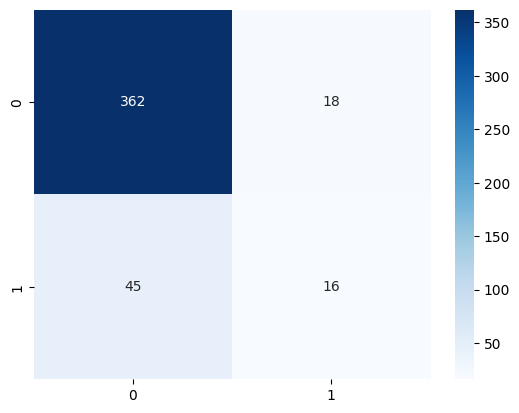

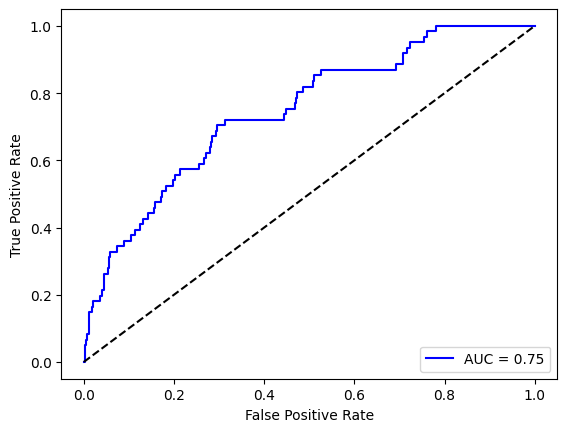

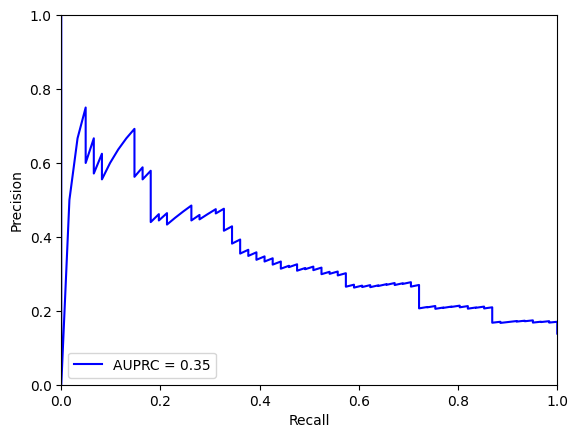

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'selector__k': [ 800,900,1000,1200,1224],  # Number of top k features to select
    'model__n_estimators': [100, 200, 300, 350, 400],  # Number of trees in the forest
    'model__max_depth': [ 5, 10, 20,30],  # Maximum depth of each tree
    'model__min_samples_split': [0,1,2, 5, 10,15],  # Minimum number of samples required to split an internal node
    'model__min_samples_leaf': [1, 2, 4,6,8]  # Minimum number of samples required to be at a leaf node
}

model_rf = RandomForestClassifier()
fun(model_rf, param_grid_rf)



# XGBoost

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1010] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1010] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1010] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/loca

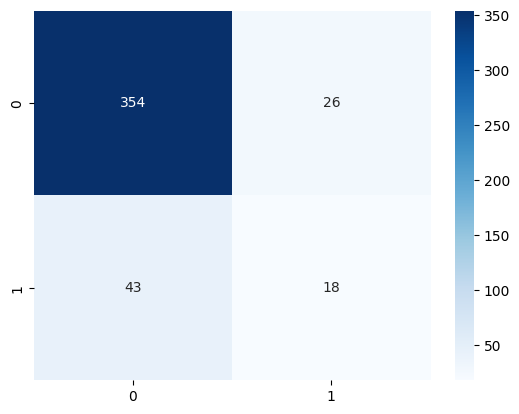

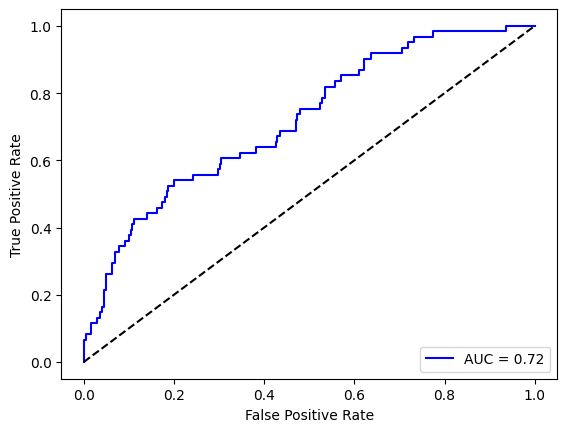

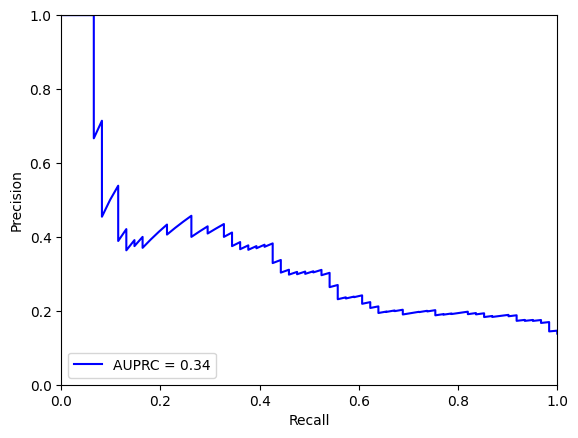

In [ ]:
from xgboost import XGBClassifier

param_grid_xgb = {
    'selector__k': [5, 15, 30, 45, 60, 80, 100],  # Number of top k features to select
    'model__learning_rate': [0.1, 0.01, 0.001],  # Learning rate
    'model__max_depth': [3, 5, 10],  # Maximum depth of each tree
    'model__n_estimators': [100, 200, 300]
}

model_xgb = XGBClassifier()
fun(model_xgb, param_grid_xgb)



/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1010] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1010] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1010] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/loca

0.3650757568862202 0.24751391024659844 0.002434379038466665 0.9715615890363639


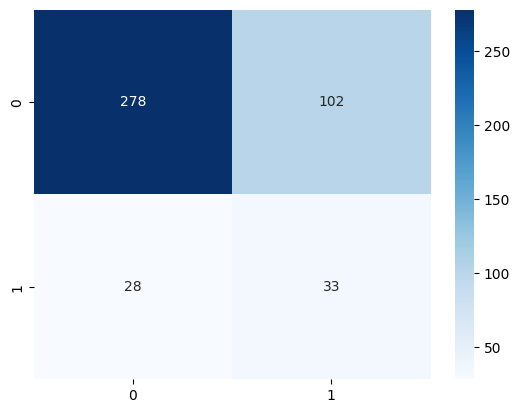

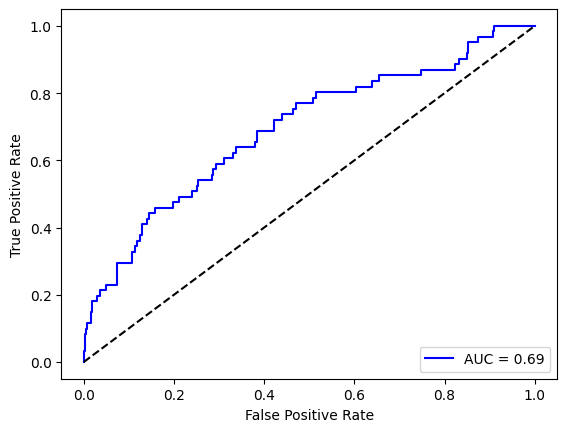

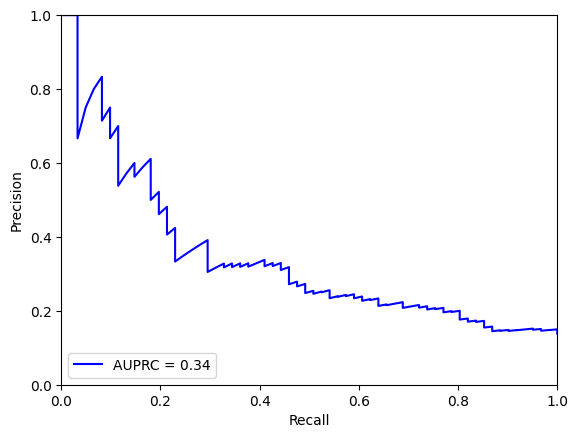

In [ ]:
from sklearn.linear_model import LogisticRegression
param_grid = {
  'selector__k': [5, 10,15, 30, 45, 60, 80, 100],
  'model__penalty': ['l1','l2'],
  'model__C': [0.1, 1.0, 10.0]
}

lr =  LogisticRegression()

fun(lr, param_grid)




# SVM

In [ ]:
from sklearn import svm
param_grid_svm = {
    "selector__k": [5,10, 15, 30, 45, 60, 80, 100,200,300,500],
    "model__C": [0.1,1,10],
    "model__kernel":['linear', 'poly', 'rbf', 'sigmoid']
}

model1 = svm.SVC(probability=True)

fun(model1, param_grid_svm)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1010] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1010] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1010] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/loca